# Train classical ML models

### Download and read data

In [1]:
import gdown

# Download training file
#train_file = 'https://drive.google.com/file/d/1RMDE3TAvbSen1XX4hV8dY0uisQsmHdRs/view?usp=sharing'
!gdown 1RMDE3TAvbSen1XX4hV8dY0uisQsmHdRs

# Download testing file
#test_file = 'https://drive.google.com/file/d/1fPSpj-mhiS4LFofOI-goLRdCzuA-HhmT/view?usp=sharing'
!gdown 1fPSpj-mhiS4LFofOI-goLRdCzuA-HhmT

Downloading...
From: https://drive.google.com/uc?id=1RMDE3TAvbSen1XX4hV8dY0uisQsmHdRs
To: /content/Train_data.csv
100% 482k/482k [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fPSpj-mhiS4LFofOI-goLRdCzuA-HhmT
To: /content/Test_data.csv
100% 180k/180k [00:00<00:00, 72.4MB/s]


In [2]:
import pandas as pd

train_file_path = '/content/Train_data.csv'
test_file_path  = '/content/Test_data.csv'

train_df = pd.read_csv(train_file_path)[['text','SDG']]
test_df = pd.read_csv(test_file_path)[['text','SDG']]

In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 4.4 MB/s 
     |████████████████████████████████| 212 kB 47.9 MB/s 
     |████████████████████████████████| 120 kB 50.2 MB/s 
     |████████████████████████████████| 115 kB 53.5 MB/s 
     |████████████████████████████████| 127 kB 37.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


None SDG dataset

In [4]:
import random

def combine_sentences(none_dataset,N_examples = 100, n_combined_sentences_per_doc=3 ):
  None_class_docs = random.choices(none_dataset, k=n_combined_sentences_per_doc*N_examples)

  new_size = int(len(None_class_docs)/n_combined_sentences_per_doc)
  None_class_docs_combined = None_class_docs[0:new_size]

  for i in range(new_size):
    for j in range(1, n_combined_sentences_per_doc):
      if None_class_docs_combined[i][-1]=='.':
        None_class_docs_combined[i] += ' '+ None_class_docs[j*new_size+i]
      else:
        None_class_docs_combined[i] += '. '+ None_class_docs[j*new_size+i]

  df_class0 = pd.DataFrame (None_class_docs_combined, columns = ['text'])
  df_class0['SDG'] = 0
  return df_class0

In [5]:
from datasets import load_dataset

def get_class0_df(No0_dataset = "glue",task = 'mnli', train_examples=100, test_examples=50, n_combined_sentences_per_doc=3):

    #task = 'mnli' #["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]
    #Glue_dataset = load_dataset(No0_dataset, task)
    none_dataset_train = load_dataset(No0_dataset, task)['train']['premise']
    none_dataset_test = load_dataset("glue", "mrpc")['test']['sentence1'] #load_dataset(No0_dataset, task)['test']['premise']

    df_class0_train = combine_sentences(none_dataset_train,N_examples = train_examples, n_combined_sentences_per_doc=n_combined_sentences_per_doc)

    train_df_withclass0 = train_df.append(df_class0_train)
    #shuffle
    train_df_withclass0 = train_df_withclass0.sample(frac=1).reset_index(drop=True)
    

    df_class0_test = combine_sentences(none_dataset_test,N_examples = test_examples, n_combined_sentences_per_doc=n_combined_sentences_per_doc)

    test_df_withclass0 = test_df.append(df_class0_test)
    #shuffle
    test_df_withclass0 = test_df_withclass0.sample(frac=1).reset_index(drop=True)
    return train_df_withclass0, test_df_withclass0

def get_dataset(with_class0 =True,with_sentence_tokenization = False):

  if with_class0:
    test_df_v1 = test_df_withclass0
    train_df_v1 = train_df_withclass0
  else:
    test_df_v1 = test_df
    train_df_v1 = train_df

  if with_sentence_tokenization:
    train_df_v2 = pd.DataFrame({'text':[], 'SDG':[]})

    for indx, row in train_df_v1.iterrows():
      for sentence in row['text'].split('. '): #The space after the point is to avoid s a split @ 1.1 -> 1, 1
        if len(sentence)>2:
          train_df_v2 = train_df_v2.append(pd.DataFrame({'text': [sentence], 'SDG':[row['SDG']]}), ignore_index=True)

    test_df_v2 = pd.DataFrame({'text':[], 'SDG':[]})

    for indx, row in test_df_v1.iterrows():
      for sentence in row['text'].split('. '):
        if len(sentence)>2:
          test_df_v2 = test_df_v2.append(pd.DataFrame({'text': [sentence], 'SDG':[row['SDG']]}), ignore_index=True)
  else:
    train_df_v2 = train_df_v1
    test_df_v2 = test_df_v1
  
  return train_df_v2, test_df_v2

### Data cleaning

In [6]:
import re
import string
import spacy
from nltk.stem import PorterStemmer
porter = PorterStemmer()

def df_cleaning(df):
  # no capital letters
  df['cleaned']=df['text'].apply(lambda x: x.lower())
  
  df['cleaned']=df['cleaned'].apply(lambda x: x.replace('“','').replace('climate change','climate_change')
  .replace(' 1',' one').replace(' 2',' two').replace(' 3',' three').replace(' 4',' four').
  replace(' 5',' five').replace(' 6',' six')
  .replace(' 7',' seven').replace(' 8',' eight').replace(' 9',' nine').replace(' 10',' ten')
  .replace(' 11',' eleven').replace(' 12',' twelve')
  .replace(' 13',' thirteen').replace(' 14',' fourteen').replace(' 15',' fifteen')
  .replace(' 16',' sixteen').replace(' 17',' seventeen').replace('goal ','goal_').replace('sdg ','sdg_')
                                   )
  
  # remove punctuations and numbers
  df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s0-9]' % re.escape(string.punctuation), '', x))

  # Loading model
  nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

  # Lemmatization with stopwords removal
  df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

  # Stem and remove numbers
  df['stemmed']=df['lemmatized'].apply(lambda x: ' '.join([porter.stem(token) for token in x.split() if not token.isnumeric() ]))
  return df

### Train-test TF-IDF sets

In [7]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_idf_sets(train_df,test_df, X_col='stemmed', Y_col='SDG',min_df=2/1000):
  #condition = (train_df['SDG']!=17) & (train_df['SDG']!=16)
  train_corpus =list(train_df[X_col])#[condition])#lemmatized
  Y_train = train_df[Y_col]#[condition]
  Y_train_arr = np.array(Y_train)
  Y_train_arr.shape

  test_corpus =list(test_df[X_col])#[condition2])#lemmatized
  Y_test = test_df[Y_col]#[condition2]
  Y_test_arr = np.array(Y_test)

  vectorizer = TfidfVectorizer(smooth_idf=True,use_idf=True, stop_words="english", analyzer='word', 
                              ngram_range=(1, 1), max_df=0.1, min_df=min_df)

  X_train_tfidf = vectorizer.fit_transform(train_corpus)
  X_test_tfidf = vectorizer.transform(test_corpus)
  print(X_train_tfidf.shape)
  return X_train_tfidf,Y_train_arr, X_test_tfidf, Y_test_arr

## Evaluation

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score#, auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def eval_classifier(Y_true,Y_pred, pred, with_class0):
  print('with None class      :', with_class0)
  print('sentence tokenization:', with_sentence_tokenization)
  acc = accuracy_score(Y_true, Y_pred)
  print('accuracy :',100*acc.round(3))

  F1_score = f1_score(Y_true, Y_pred, average='weighted')#micro, macro, weighted
  print('f1_score :',100*F1_score.round(3))

  precision = precision_score(Y_true, Y_pred, average='weighted')#micro, macro, weighted
  print('precision:',100*precision.round(3))

  recall = recall_score(Y_true, Y_pred, average='macro')#micro, macro, weighted
  print('recall   :',100*recall.round(3))

  roc_auc = roc_auc_score(Y_true, pred, multi_class='ovo') #'raise', 'ovr', 'ovo'
  print('roc_auc  :',100*roc_auc.round(3))


  fig, ax = plt.subplots(figsize=(10, 5))
  ConfusionMatrixDisplay.from_predictions(Y_true, Y_pred, ax=ax)
  n_classes = np.max(Y_true)
  if with_class0:
    ax.xaxis.set_ticklabels(np.arange(0,n_classes+1))
    ax.yaxis.set_ticklabels(np.arange(0,n_classes+1))
  else:
    ax.xaxis.set_ticklabels(np.arange(1,n_classes+1))
    ax.yaxis.set_ticklabels(np.arange(1,n_classes+1))
  _ = ax.set_title(
      f"Confusion Matrix for {clf.__class__.__name__}"
  )

## Train models

In [ ]:
with_class0 = True
with_sentence_tokenization = False

if with_sentence_tokenization:
  min_df = 1/1000
  n_combined_sentences_per_doc = 1
  test_examples = 75
  train_examples=150
else: 
  min_df = 2/1000
  n_combined_sentences_per_doc =3
  test_examples = 50
  train_examples=100

In [ ]:
train_df_withclass0, test_df_withclass0 = get_class0_df(No0_dataset = "glue",task = 'mnli',
                                                        train_examples=train_examples, test_examples=test_examples, 
                                                        n_combined_sentences_per_doc=n_combined_sentences_per_doc)

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_df_v2, test_df_v2 = get_dataset(with_class0,with_sentence_tokenization)
train_df_v3 = df_cleaning(train_df_v2)
test_df_v3 = df_cleaning(test_df_v2)
X_train_tfidf,Y_train_arr, X_test_tfidf, Y_test_arr = tf_idf_sets(train_df_v3,test_df_v3, X_col='stemmed', Y_col='SDG',min_df=min_df)

(1764, 1394)


-------Test set---------
with None class      : True
sentence tokenization: False
accuracy : 75.2
f1_score : 75.7
precision: 78.60000000000001
recall   : 73.8
roc_auc  : 95.7


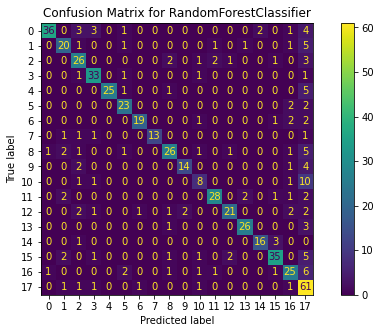

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=200, max_features=5, min_samples_split= 3,
    n_estimators=250).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)
print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0 )

In [ ]:
with_class0 = True
with_sentence_tokenization = False

if with_sentence_tokenization:
  min_df = 1/1000
  n_combined_sentences_per_doc = 1
  test_examples = 75
  train_examples=150
else: 
  min_df = 2/1000
  n_combined_sentences_per_doc =3
  test_examples = 50
  train_examples=100

train_df_withclass0, test_df_withclass0 = get_class0_df(No0_dataset = "glue",task = 'mnli',
                                                        train_examples=train_examples, test_examples=test_examples, 
                                                        n_combined_sentences_per_doc=n_combined_sentences_per_doc)

train_df_v2, test_df_v2 = get_dataset(with_class0,with_sentence_tokenization)
train_df_v3 = df_cleaning(train_df_v2)
test_df_v3 = df_cleaning(test_df_v2)
X_train_tfidf2,Y_train_arr2, X_test_tfidf2, Y_test_arr2 = tf_idf_sets(train_df_v3,test_df_v3, X_col='stemmed', Y_col='SDG',min_df=min_df)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

(1764, 1387)


In [ ]:
pred_test = clf.predict_proba(X_test_tfidf2)
Y_test_pred = clf.predict(X_test_tfidf2)
print('-------Test set---------')
eval_classifier(Y_test_arr2,Y_test_pred, pred_test, with_class0 )

ValueError: ignored

-------Test set---------
with None class      : True
sentence tokenization: False
accuracy : 71.2
f1_score : 71.39999999999999
precision: 73.6
recall   : 70.0
roc_auc  : 95.0


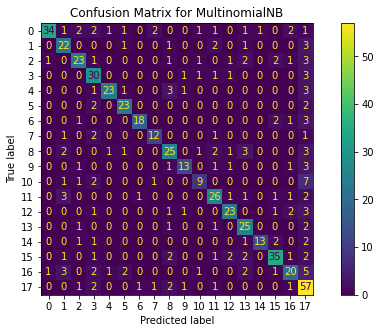

In [ ]:
clf = MultinomialNB(alpha=0.9,fit_prior=False).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)

print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0)

-------Test set---------
with None class      : True
sentence tokenization: False
accuracy : 74.2
f1_score : 74.6
precision: 77.8
recall   : 73.0
roc_auc  : 95.6


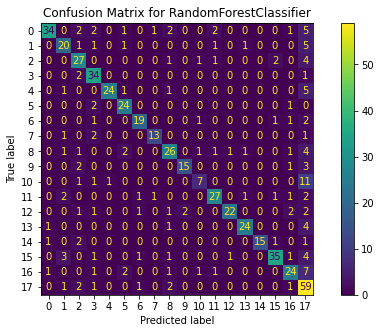

In [ ]:
clf = RandomForestClassifier(max_depth=200, max_features=5, min_samples_split= 3,
    n_estimators=250).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)
print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0 )

-------Test set---------
with None class      : True
sentence tokenization: True
accuracy : 57.099999999999994
f1_score : 57.4
precision: 62.2
recall   : 57.599999999999994
roc_auc  : 90.0


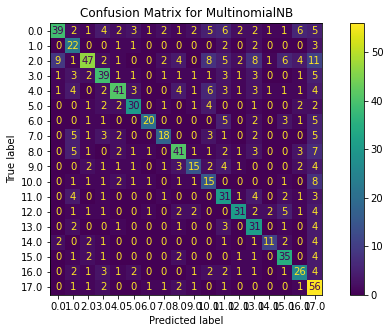

In [ ]:
clf = MultinomialNB(alpha=0.7,fit_prior=False).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)

print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0)

-------Test set---------
with None class      : True
sentence tokenization: True
accuracy : 62.3
f1_score : 62.8
precision: 66.8
recall   : 61.9
roc_auc  : 90.5


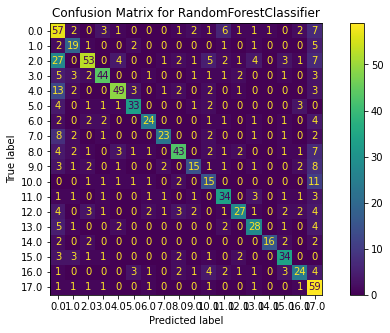

In [ ]:
clf = RandomForestClassifier(max_depth=200, max_features=5, min_samples_split= 3,
    n_estimators=150).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)
print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0 )

### Naive Bays model

-------Training set---------
with None class      : True
sentence tokenization: False
accuracy : 78.3
f1_score : 78.7
precision: 86.1
recall   : 73.5
roc_auc  : 99.5


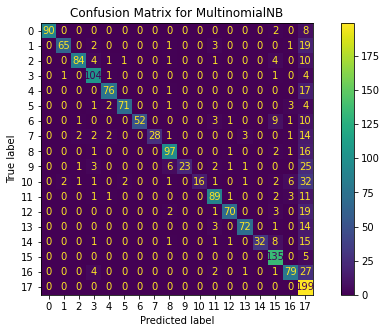

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf,Y_train_arr)

train_pred = clf.predict_proba(X_train_tfidf)
Y_train_pred = clf.predict(X_train_tfidf)

print('-------Training set---------')
eval_classifier(Y_train_arr,Y_train_pred, train_pred,with_class0 )

-------Test set---------
with None class      : True
sentence tokenization: False
accuracy : 62.8
f1_score : 64.1
precision: 78.8
recall   : 56.699999999999996
roc_auc  : 94.39999999999999


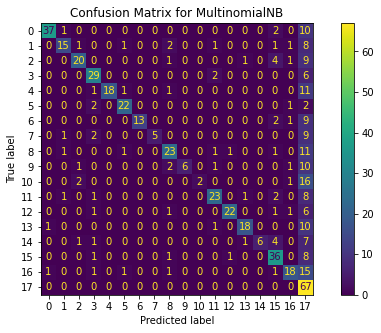

In [ ]:
pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)

print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0)

-------Test set---------
with None class      : True
sentence tokenization: True
accuracy : 57.099999999999994
f1_score : 57.699999999999996
precision: 62.8
recall   : 57.099999999999994
roc_auc  : 90.3


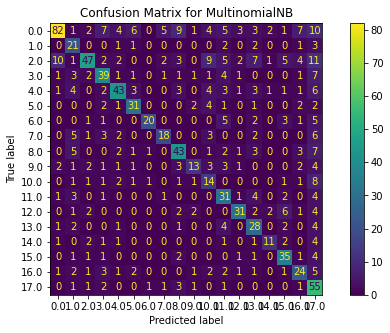

In [ ]:
clf = MultinomialNB(alpha=0.9,fit_prior=False).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)

print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0)

-------Test set---------
with None class      : False
sentence tokenization: True
accuracy : 58.099999999999994
f1_score : 58.5
precision: 63.4
recall   : 58.099999999999994
roc_auc  : 90.2


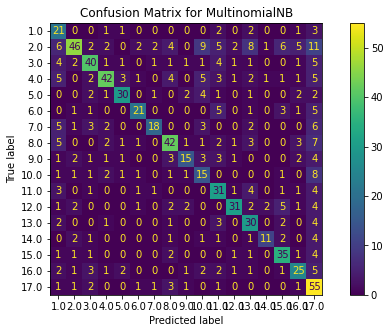

In [ ]:
clf = MultinomialNB(alpha=0.9,fit_prior=False).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)

print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0)

-------Test set---------
with None class      : True
sentence tokenization: False
accuracy : 72.2
f1_score : 72.3
precision: 74.6
recall   : 70.6
roc_auc  : 95.19999999999999


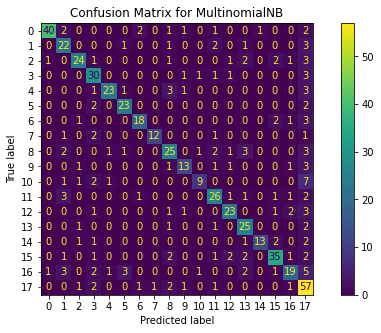

In [ ]:
clf = MultinomialNB(alpha=0.9,fit_prior=False).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)

print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0)

### Ramdom Forests

-------Test set---------
with None class      : True
sentence tokenization: False
accuracy : 71.2
f1_score : 71.8
precision: 74.1
recall   : 70.39999999999999
roc_auc  : 94.69999999999999


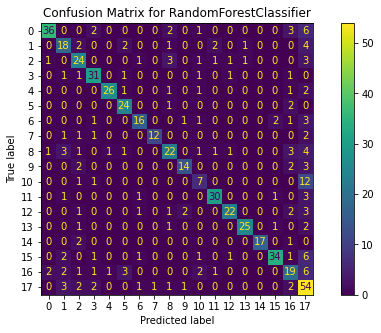

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# No balancing, n_estimators=100

clf = RandomForestClassifier(n_estimators=100).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)

print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0 )

-------Test set---------
with None class      : True
sentence tokenization: False
accuracy : 71.6
f1_score : 71.7
precision: 73.4
recall   : 70.1
roc_auc  : 94.5


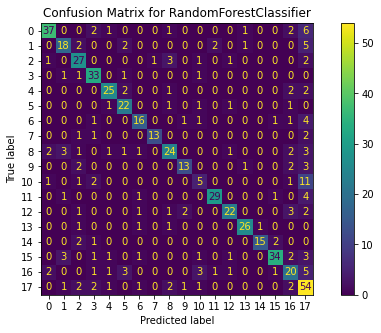

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# No balancing, n_estimators=50
clf = RandomForestClassifier(n_estimators=50).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)

print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0 )

-------Test set---------
with None class      : True
sentence tokenization: True
accuracy : 62.6
f1_score : 62.4
precision: 69.0
recall   : 59.099999999999994
roc_auc  : 89.60000000000001


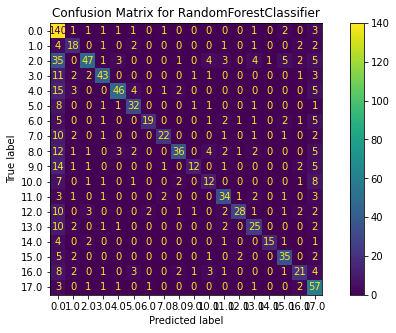

In [ ]:
clf = RandomForestClassifier(max_depth=200, max_features=5, min_samples_split= 3,
    n_estimators=100).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)
print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0 )

-------Test set---------
with None class      : False
sentence tokenization: True
accuracy : 63.2
f1_score : 63.9
precision: 68.7
recall   : 63.2
roc_auc  : 91.2


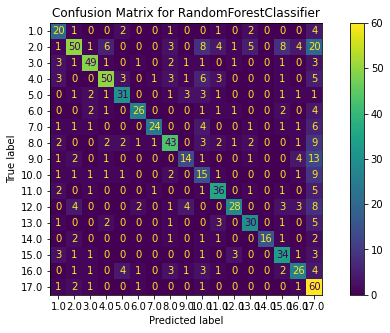

In [ ]:
clf = RandomForestClassifier(max_depth=200, max_features=5, min_samples_split= 3,
    n_estimators=250).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)
print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0 )

### fine tuning

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

clf = RandomForestClassifier(n_jobs=-1)


param_grid = {
    'min_samples_split': [1, 2, 3, 4,5, 10, 20], 
    'n_estimators' : [50, 100, 150, 200,250],
    'max_depth': [50, 100, 150, 200,250,300],
    'max_features': [5,10, 20, 30,40,50,100]
}

scorers = {
    #'precision_score': make_scorer(precision_score),
    #'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_tfidf, Y_train_arr)

    # make the predictions
    y_pred = grid_search.predict(X_test_tfidf)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2100 fits failed out of a total of 14700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 

Best params for accuracy_score
{'max_depth': 200, 'max_features': 5, 'min_samples_split': 3, 'n_estimators': 250}


In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_accuracy_score', ascending=False)
results[['mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
749,0.727,200,5,3,250
504,0.727,150,5,3,250
999,0.726,250,5,4,250
1249,0.725,300,5,5,250
503,0.725,150,5,3,200


-------Test set---------
with None class      : True
sentence tokenization: False
accuracy : 75.4
f1_score : 75.9
precision: 78.9
recall   : 73.9
roc_auc  : 95.8


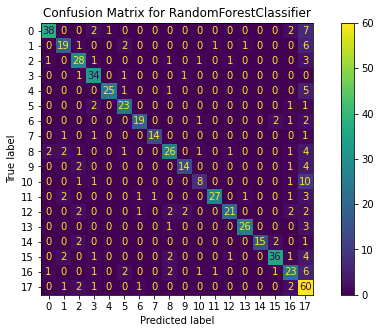

In [ ]:
clf = RandomForestClassifier(max_depth=200, max_features=5, min_samples_split= 3,
    n_estimators=250).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)
print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0 )

-------Test set---------
accuracy : 75.0
f1_score : 75.4
precision: 78.10000000000001
recall   : 73.5
roc_auc  : 95.3


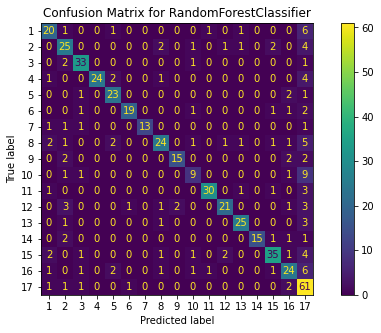

In [ ]:
# with balancing
clf = RandomForestClassifier(max_depth=200, max_features=5, min_samples_split= 3,
    n_estimators=200).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)
print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test )

In [ ]:
with_class0 = True
with_sentence_tokenization = False

train_df_v2, test_df_v2 = get_dataset(with_class0,with_sentence_tokenization)
train_df_v3 = df_cleaning(train_df_v2)
test_df_v3 = df_cleaning(test_df_v2)
X_train_tfidf,Y_train_arr, X_test_tfidf, Y_test_arr = tf_idf_sets(train_df_v3,test_df_v3, X_col='stemmed', Y_col='SDG',min_df=2/1000)

clf = MultinomialNB(alpha=0.9,fit_prior=False).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)

print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0)

## Save Models

In [ ]:
import pandas as pd

train_file_path = '/content/Train_data.csv'
test_file_path  = '/content/Test_data.csv'

train_df = pd.read_csv(train_file_path)[['text','SDG']]
test_df = pd.read_csv(test_file_path)[['text','SDG']]

In [9]:
train_df

,text,SDG
0,"Furthermore, the need to “Protect, restore and...",15
1,Implementing sustainable development goal 11 i...,11
2,which aims to “develop and implement tools to ...,8
3,It was acknowledged that fundamental changes i...,12
4,"Furthermore, it provided guidelines for natura...",11
...,...,...
1659,"Amongst numerous commitments, the Conference c...",8
1660,Proportion of fish stocks within biologically ...,14
1661,"In paragraph 23, Member States renewed the com...",12
1662,Chapter 21 was considered by the Commission on...,12


In [113]:
with_class0 = True
with_sentence_tokenization = False

min_df = 0/1000
n_combined_sentences_per_doc =3

test_examples = 50
train_examples=150

#train_df_withclass0, test_df_withclass0 = get_class0_df(train_examples=train_examples, test_examples=test_examples, 
#                                                        n_combined_sentences_per_doc=n_combined_sentences_per_doc)

In [114]:
none_dataset_train = load_dataset("glue", 'mnli')['train']['premise']
none_dataset_test = load_dataset("glue", "mrpc")['test']['sentence1']

df_class0_train = combine_sentences(none_dataset_train,N_examples = 200, n_combined_sentences_per_doc=3)

train_df_withclass0 = train_df.append(df_class0_train)
#shuffle
train_df_withclass0 = train_df_withclass0.sample(frac=1).reset_index(drop=True)


df_class0_test = combine_sentences(none_dataset_test,N_examples = 50, n_combined_sentences_per_doc=3)

test_df_withclass0 = test_df.append(df_class0_test)
#shuffle
test_df_withclass0 = test_df_withclass0.sample(frac=1).reset_index(drop=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [115]:
train_df_v2, test_df_v2 = get_dataset(with_class0, with_sentence_tokenization)

train_df_no0class_cleaned = df_cleaning(train_df)

train_df_v3 = df_cleaning(train_df_v2)
test_df_v3 = df_cleaning(test_df_v2)

In [116]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_idf_sets(vectorizer, df, X_col='stemmed', Y_col='SDG',min_df=min_df):

  Y_arr = np.array(df[Y_col])

  corpus =list(df[X_col])
  X_tfidf = vectorizer.transform(corpus)

  return X_tfidf, Y_arr

In [117]:
X_col='stemmed'

vectorizer = TfidfVectorizer(smooth_idf=True,use_idf=True, stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=0.3, min_df=min_df,norm='l2')

tfidf_corpus =list(train_df_v3[X_col])
X_train_tfidf0 = vectorizer.fit_transform(tfidf_corpus)

X_train_tfidf,Y_train_arr = tf_idf_sets(vectorizer, train_df_v3, X_col='stemmed', Y_col='SDG',min_df=min_df)
X_test_tfidf, Y_test_arr = tf_idf_sets(vectorizer, test_df_v3, X_col='stemmed', Y_col='SDG',min_df=min_df)

-------Test set---------
with None class      : True
sentence tokenization: False
accuracy : 73.9
f1_score : 74.3
precision: 78.5
recall   : 70.39999999999999
roc_auc  : 96.1


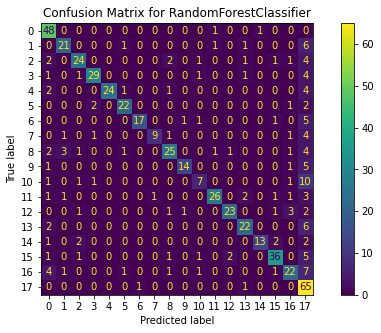

In [119]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=200, max_features=5, min_samples_split= 3,
    n_estimators=250).fit(X_train_tfidf,Y_train_arr)

pred_test = clf.predict_proba(X_test_tfidf)
Y_test_pred = clf.predict(X_test_tfidf)
print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0 )

-------Test set---------
with None class      : True
sentence tokenization: False
accuracy : 71.6
f1_score : 72.0
precision: 77.2
recall   : 68.30000000000001
roc_auc  : 95.0


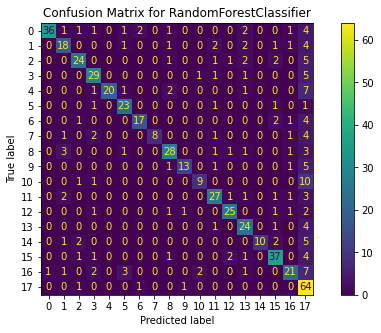

In [128]:
from sklearn.naive_bayes import MultinomialNB

clf_NB = MultinomialNB(alpha=0.25,fit_prior=False).fit(X_train_tfidf,Y_train_arr)

pred_test = clf_NB.predict_proba(X_test_tfidf)
Y_test_pred = clf_NB.predict(X_test_tfidf)

print('-------Test set---------')
eval_classifier(Y_test_arr,Y_test_pred, pred_test, with_class0 )

In [129]:
import pickle
with open('vectorizer.pk', 'wb') as fin:
   pickle.dump(vectorizer, fin)

with open('RF_classifier.pk', 'wb') as fin:
   pickle.dump(clf, fin)

with open('NB_classifier.pk', 'wb') as fin:
   pickle.dump(clf_NB, fin)

# Load and Run model

In [1]:
Class2SDG = {
    0: 'Not SDG',
    1: 'NO POVERTY',
    2: 'ZERO HUNGER',
    3: 'GOOD HEALTH AND WELL-BEING',
    4: 'QUALITY EDUCATION',
    5: 'GENDER EQUALITY',
    6: 'CLEAN WATER AND SANITATION',
    7: 'AFFORDABLE AND CLEAN ENERGY',
    8: 'DECENT WORK AND ECONOMIC GROWTH',
    9: 'INDUSTRY, INNOVATION, AND INFRASTRUCTURE',
    10: 'REDUCED INEQUALITIES',
    11: 'SUSTAINABLE CITIES AND COMMUNITIES',
    12: 'RESPONSIBLE CONSUMPTION AND PRODUCTION',
    13: 'CLIMATE ACTION',
    14: 'LIFE BELOW WATER',
    15: 'LIFE ON LAND',
    16: 'PEACE, JUSTICE AND STRONG INSTITUTIONS',
    17: 'PARTNERSHIPS',
}

In [4]:
# https://drive.google.com/file/d/1GrVxmBnSkrbf4UOu7Mdq7evgtd6jc_X-/view?usp=sharing
!gdown 1GrVxmBnSkrbf4UOu7Mdq7evgtd6jc_X-

#https://drive.google.com/file/d/1laLhm0_S_4PYcl1B8XPmIQTUT7p3quoz/view?usp=sharing
!gdown 1laLhm0_S_4PYcl1B8XPmIQTUT7p3quoz

#https://drive.google.com/file/d/1s9Azod5GrR1trlGLIX9qXi28XG3kO4Mf/view?usp=sharing
!gdown 1s9Azod5GrR1trlGLIX9qXi28XG3kO4Mf

import pickle

with open('vectorizer.pk', 'rb') as fin:
   vectorizer = pickle.load(fin)

with open('RF_classifier.pk', 'rb') as fin:
   clf_RF = pickle.load(fin)

with open('NB_classifier.pk', 'rb') as fin:
   clf_NB = pickle.load(fin)

Downloading...
From: https://drive.google.com/uc?id=1GrVxmBnSkrbf4UOu7Mdq7evgtd6jc_X-
To: /content/vectorizer.pk
100% 183k/183k [00:00<00:00, 58.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1laLhm0_S_4PYcl1B8XPmIQTUT7p3quoz
To: /content/RF_classifier.pk
100% 65.2M/65.2M [00:00<00:00, 191MB/s]
Downloading...
From: https://drive.google.com/uc?id=1s9Azod5GrR1trlGLIX9qXi28XG3kO4Mf
To: /content/NB_classifier.pk
100% 1.48M/1.48M [00:00<00:00, 107MB/s]


In [5]:
import re
import string
import spacy
from nltk.stem import PorterStemmer
porter = PorterStemmer()
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

def stem_sentence(sentence):
  sent_cleaned = sentence.lower().replace('“','').replace('climate change','climate_change').replace(
      ' 1',' one').replace(' 2',' two').replace(' 3',' three').replace(' 4',' four').replace(
      ' 5',' five').replace(' 6',' six').replace(' 7',' seven').replace(
      ' 8',' eight').replace(' 9',' nine').replace(' 10',' ten').replace(
      ' 11',' eleven').replace(' 12',' twelve').replace(' 13',' thirteen').replace(
      ' 14',' fourteen').replace(' 15',' fifteen').replace(' 16',' sixteen').replace(
      ' 17',' seventeen').replace('goal ','goal_').replace('sdg ','sdg_')

  sent_cleaned = re.sub('[%s0-9]' % re.escape(string.punctuation), '', sent_cleaned)

  sent_cleaned = ' '.join([token.lemma_ for token in list(nlp(sent_cleaned)) if (token.is_stop==False)])

  sent_cleaned = ' '.join([porter.stem(token) for token in sent_cleaned.split() if not token.isnumeric() ])
  return sent_cleaned

In [7]:
def predict_sentence(sentence,clf):
  senetnces = [stem_sentence(sentence)]
  Xin = vectorizer.transform(list(senetnces))
  y_out = clf.predict(Xin)

  classes = [Class2SDG[y] for y in y_out]

  print('Stem      :', senetnces)
  print('Class',y_out,':',classes)
  return y_out

In [8]:
sentence= 'At the same session, the Assembly proclaimed, with the adoption of Resolution 55/284, "2001-2010 as Decade to Roll Back Malaria in Developing Countries, Particularly in Africa".'

In [9]:
predict_sentence(sentence,clf_RF)

Stem      : ['session assembl proclaim adopt resolut decad roll malaria develop countri particularli africa']
Class [3] : ['GOOD HEALTH AND WELL-BEING']


array([3])

In [10]:
predict_sentence(sentence,clf_NB)

Stem      : ['session assembl proclaim adopt resolut decad roll malaria develop countri particularli africa']
Class [3] : ['GOOD HEALTH AND WELL-BEING']


array([3])

In [26]:
predict_sentence('test a none class',clf_RF)

Stem      : ['test class']
Class [0] : ['Not SDG']


array([0])

In [25]:
predict_sentence('test a none class',clf_NB)

Stem      : ['test class']
Class [0] : ['Not SDG']


array([0])